<a href="https://colab.research.google.com/github/ariesslin/ie7500-g1-tweet-sentiment-nlp/blob/main/scripts/3.%20Model_Development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>3b. Deep Learning Model – Bidirectional LSTM</strong></h2>
  <p style="color:#333333;">Bidirectional LSTM with Word2Vec embeddings for sequence-aware sentiment analysis.</p>
</div>

## Deep Learning Sentiment Classifier: Bidirectional LSTM with Word2Vec Embeddings

This notebook implements a **deep learning model** for tweet sentiment classification using **Bidirectional LSTM** networks combined with **Word2Vec word embeddings**.

### Why Bidirectional LSTM?

- **Sequential Understanding**: Unlike the TF-IDF baseline, LSTMs can capture the **sequential nature** of language, understanding how words relate to each other in context.
- **Bidirectional Processing**: By processing text both forward and backward, the model gains a more complete understanding of context around each word.
- **Long-term Dependencies**: LSTMs excel at capturing relationships between words that are far apart in a sentence, crucial for understanding sentiment in complex tweets.
- **Contextual Awareness**: Can handle negation, sarcasm, and other linguistic nuances that bag-of-words models miss.

### Why Word2Vec Embeddings?

Instead of sparse TF-IDF vectors, we use **dense Word2Vec embeddings** that capture semantic relationships between words. Words with similar meanings are positioned close to each other in the embedding space, allowing the model to generalize better to unseen vocabulary and understand semantic similarity.

### What This Notebook Covers

- Loads and preprocesses the training and validation datasets
- Trains a custom Word2Vec model on the tweet corpus
- Builds bidirectional LSTM architecture with embedding layers
- Implements proper text tokenization and sequence padding
- Trains the model with early stopping and performance monitoring
- Evaluates performance using accuracy, precision, recall, F1-score, and confusion matrix
- Provides analysis of model strengths and limitations

This LSTM model represents a significant step up in complexity from our logistic regression baseline, designed to capture the nuanced, context-dependent nature of sentiment in social media text.


In [ ]:
# Mount Google Drive and Setup Project Environment
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
PROJECT_ROOT = "/content/drive/MyDrive/northeastern/ie7500/ie7500-g1-tweet-sentiment-nlp"


In [ ]:
train_path = f"{PROJECT_ROOT}/processed_data/train_dataset.csv"
val_path = f"{PROJECT_ROOT}/processed_data/val_dataset.csv"


In [ ]:
import sys
!{sys.executable} -m pip install -r "{PROJECT_ROOT}/requirements.txt"


### GPU Configuration

Due to compatibility issues with CuDNN in the current environment, we'll configure TensorFlow to use CPU-only mode for training. While this will be slower, it ensures reliable execution across different environments.

In [ ]:
import tensorflow as tf

# Hide all GPUs at runtime (must be done before anything else in TensorFlow)
tf.config.set_visible_devices([], 'GPU')

print("After disabling:", tf.config.get_visible_devices())


After disabling: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [ ]:
# Import required libraries for LSTM model development
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Gensim for Word2Vec embeddings and text preprocessing
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

# TensorFlow/Keras for deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Nadam

# Scikit-learn for evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)

# Project utilities
sys.path.append(f"{PROJECT_ROOT}/utils")
from helper import load_clean_train_val_datasets

/courses/IE7500.202550/shared/conda_env_1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
train_df, val_df = load_clean_train_val_datasets(train_path, val_path)

In [ ]:
train_df.head()


In [ ]:
val_df.head()


### Data Preparation for LSTM Model

For the LSTM model, we need to prepare the data differently than for the logistic regression baseline:

1. **Text Tokenization**: Convert tweets into sequences of tokens using Gensim's `simple_preprocess`
2. **Word2Vec Training**: Train embeddings on our tokenized corpus to capture semantic relationships
3. **Sequence Conversion**: Transform text into numerical sequences for neural network input
4. **Padding**: Ensure all sequences have the same length for batch processing
5. **Target Encoding**: Convert sentiment labels to binary format (0/1) for sigmoid output

This preparation enables the LSTM to understand both the sequential nature of text and the semantic meaning of individual words.


In [ ]:
# Extract features and targets, ensuring proper data types
X_train = train_df['text'].astype(str)
y_train = train_df['target'].astype(int).replace({4: 1})  # Remap 4 → 1 for binary classification

X_val = val_df['text'].astype(str)
y_val = val_df['target'].astype(int).replace({4: 1})

# Display data shapes
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("X_train shape:", X_train.shape, "| y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape, "| y_val shape:", y_val.shape)


In [ ]:
# Tokenize tweets using Gensim's simple_preprocess
# This function handles lowercase conversion, removes punctuation, and filters short tokens
tokenized_train = X_train.apply(simple_preprocess).tolist()
tokenized_val = X_val.apply(simple_preprocess).tolist()

print(f"Tokenized {len(tokenized_train)} training tweets")
print(f"Tokenized {len(tokenized_val)} validation tweets")
print(f"Sample tokenized tweet: {tokenized_train[0][:10]}...")  # Show first 10 tokens


In [ ]:
### Word2Vec Embedding Training

# Train Word2Vec model on our tokenized tweet corpus
embedding_dim = 100  # Dimensionality of word vectors

word2vec_model = Word2Vec(
    sentences=tokenized_train,
    vector_size=embedding_dim,
    window=10,           # Maximum distance between current and predicted word
    min_count=2,         # Ignore words with frequency less than this
    sg=1,               # Use skip-gram algorithm (1) vs CBOW (0)
    seed=42,            # For reproducibility
    workers=10          # Number of threads for training
)

# Extract the KeyedVectors for efficient lookup
word_vectors = word2vec_model.wv

print(f"Word2Vec model trained with {len(word_vectors)} unique words")
print(f"Embedding dimension: {embedding_dim}")
print(f"Sample similar words to 'good': {word_vectors.most_similar('good', topn=5) if 'good' in word_vectors else 'N/A'}")

In [ ]:
### Keras Tokenizer Setup

# Join tokens back into space-separated strings for Keras compatibility
tokenized_train_texts = [' '.join(tokens) for tokens in tokenized_train]
tokenized_val_texts = [' '.join(tokens) for tokens in tokenized_val]

# Initialize and fit Keras tokenizer
# Note: We limit vocabulary to match our Word2Vec model to ensure full embedding coverage
tokenizer = Tokenizer(num_words=len(word_vectors) + 1)
tokenizer.fit_on_texts(tokenized_train_texts)

word_index = tokenizer.word_index
print(f"Keras tokenizer vocabulary size: {len(word_index)}")
print(f"Limited to top {tokenizer.num_words} words")

In [ ]:
### Building the Embedding Matrix

# Create embedding matrix that maps tokenizer indices to Word2Vec vectors
embedding_matrix = np.zeros((tokenizer.num_words, embedding_dim))

words_found = 0
for word, i in word_index.items():
    if i >= tokenizer.num_words:
        continue
    if word in word_vectors:
        embedding_matrix[i] = word_vectors[word]
        words_found += 1

coverage = words_found / tokenizer.num_words
print(f"Words matched in Word2Vec: {words_found}/{tokenizer.num_words}")
print(f"Embedding coverage: {coverage:.2%}")

if coverage < 0.5:
    print("⚠️  Warning: Low embedding coverage detected")
    print("   This may affect model performance - consider adjusting tokenizer vocabulary")

### Text Sequence Processing

Now we convert our tokenized text into numerical sequences that the LSTM can process, and ensure all sequences have uniform length through padding.

# Convert text to numerical sequences
X_train_seq = tokenizer.texts_to_sequences(tokenized_train_texts)
X_val_seq = tokenizer.texts_to_sequences(tokenized_val_texts)

# Determine maximum sequence length for padding
max_len = max(len(seq) for seq in X_train_seq)
print(f"Maximum sequence length: {max_len}")

# Pad sequences to ensure uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')

print(f"Training sequences shape: {X_train_pad.shape}")
print(f"Validation sequences shape: {X_val_pad.shape}")


In [ ]:
# Convert targets to binary format for neural network training
y_train_binary = np.where(y_train == 4, 1.0, 0.0).astype(np.float32)
y_val_binary = np.where(y_val == 4, 1.0, 0.0).astype(np.float32)

print(f"Target distribution (training): {np.bincount(y_train_binary.astype(int))}")
print(f"Target distribution (validation): {np.bincount(y_val_binary.astype(int))}")

### Model Architecture Design

Now we'll build our Bidirectional LSTM model with the following architecture:
- **Embedding Layer**: Uses our pre-trained Word2Vec embeddings
- **Bidirectional LSTM Layers**: Process sequences in both directions to capture full context
- **Dropout Layers**: Prevent overfitting during training
- **Dense Output Layer**: Binary classification with sigmoid activation

The bidirectional approach allows the model to consider both past and future context when processing each word, leading to better understanding of sentiment patterns.


### Sanity Check: Small-Scale Model Test

Before training on the full dataset, we'll verify our model architecture works correctly by training on a small subset. This helps identify potential issues early and ensures the model can learn from the data.


In [ ]:
# Create small subset for sanity testing
subset_size = 100
X_small = X_train_pad[:subset_size]
y_small = y_train_binary[:subset_size]

print(f"Sanity check on {subset_size} samples")
print(f"Small dataset shape: {X_small.shape}")
print(f"Small targets shape: {y_small.shape}")


In [ ]:
# Build simple LSTM model for sanity check
sanity_model = Sequential([
    Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights=[embedding_matrix],
        trainable=True,
        name='embedding_layer'
    ),
    Bidirectional(LSTM(64), name='bidirectional_lstm'),
    Dense(1, activation='sigmoid', name='output_layer')
])

# Compile the model
sanity_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print("Sanity check model architecture:")
sanity_model.summary()

# Train on small subset to verify learning capability
print("\\nTraining sanity check model...")
sanity_history = sanity_model.fit(
    X_small, y_small,
    epochs=10,
    batch_size=10,
    verbose=1
)

# Check if model learned (accuracy should improve)
final_acc = sanity_history.history['accuracy'][-1]
print(f"\\nSanity check result: Final accuracy = {final_acc:.3f}")
if final_acc > 0.7:
    print("✅ Model architecture works - proceeding with full training")
else:
    print("⚠️  Model may have issues - consider debugging before full training")

Epoch 1/20


/courses/IE7500.202550/shared/conda_env_1/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1750847147.521196  421565 service.cc:152] XLA service 0x14e7f000d0b0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750847147.521239  421565 service.cc:160]   StreamExecutor device (0): Host, Default Version
2025-06-25 06:25:47.587631: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750847148.461437  421565 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 - 4s - 361ms/step - accuracy: 0.5600 - loss: 0.6938
Epoch 2/20
10/10 - 0s - 33ms/step - accuracy: 0.6900 - loss: 0.6432
Epoch 3/20
10/10 - 0s - 33ms/step - accuracy: 0.7700 - loss: 0.5872
Epoch 4/20
10/10 - 0s - 33ms/step - accuracy: 0.7900 - loss: 0.4878
Epoch 5/20
10/10 - 0s - 33ms/step - accuracy: 0.8600 - loss: 0.3572
Epoch 6/20
10/10 - 0s - 33ms/step - accuracy: 0.9000 - loss: 0.2679
Epoch 7/20
10/10 - 0s - 33ms/step - accuracy: 0.9400 - loss: 0.1936
Epoch 8/20
10/10 - 0s - 33ms/step - accuracy: 0.9700 - loss: 0.1019
Epoch 9/20
10/10 - 0s - 33ms/step - accuracy: 0.9900 - loss: 0.0595
Epoch 10/20
10/10 - 0s - 33ms/step - accuracy: 0.9900 - loss: 0.0391
Epoch 11/20
10/10 - 0s - 33ms/step - accuracy: 0.9900 - loss: 0.0308
Epoch 12/20
10/10 - 0s - 33ms/step - accuracy: 0.9900 - loss: 0.0253
Epoch 13/20
10/10 - 0s - 33ms/step - accuracy: 0.9900 - loss: 0.0241
Epoch 14/20
10/10 - 0s - 33ms/step - accuracy: 0.9900 - loss: 0.0190
Epoch 15/20
10/10 - 0s - 33ms/step - accuracy: 0.9900

In [ ]:
### Full-Scale LSTM Model Architecture

# Build production LSTM model with deeper architecture
lstm_model = Sequential([
    # Embedding layer with pre-trained Word2Vec weights
    Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights=[embedding_matrix],
        trainable=False,  # Keep Word2Vec weights frozen
        name='word2vec_embedding'
    ),
    
    # First bidirectional LSTM layer
    Bidirectional(LSTM(128, return_sequences=True), name='lstm_layer_1'),
    Dropout(0.3, name='dropout_1'),
    
    # Second bidirectional LSTM layer
    Bidirectional(LSTM(64), name='lstm_layer_2'),
    Dropout(0.3, name='dropout_2'),
    
    # Output layer for binary classification
    Dense(1, activation='sigmoid', name='sentiment_output')
])

# Compile with Nadam optimizer for better convergence
lstm_model.compile(
    loss='binary_crossentropy',
    optimizer=Nadam(learning_rate=0.001),
    metrics=['accuracy']
)

print("Production LSTM Model Architecture:")
lstm_model.summary()

# Display model parameters
total_params = lstm_model.count_params()
print(f"\\nTotal trainable parameters: {total_params:,}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     8,201,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,201,400 (31.29 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 8,201,400 (31.29 MB)

Epoch 1/20
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 1077s 571ms/step - accuracy: 0.7712 - loss: 0.4744 - val_accuracy: 0.7955 - val_loss: 0.4364
Epoch 2/20
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 1065s 568ms/step - accuracy: 0.7994 - loss: 0.4315 - val_accuracy: 0.8021 - val_loss: 0.4271
Epoch 3/20
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 1062s 567ms/step - accuracy: 0.8059 - loss: 0.4210 - val_accuracy: 0.8069 - val_loss: 0.4185
Epoch 4/20
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 1062s 567ms/step - accuracy: 0.8101 - loss: 0.4132 - val_accuracy: 0.8071 - val_loss: 0.4166
Epoch 5/20
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 1061s 566ms/step - accuracy: 0.8145 - loss: 0.4050 - val_accuracy: 0.8099 - val_loss: 0.4131
Epoch 6/20
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 1061s 566ms/step - accuracy: 0.8184 - loss: 0.3981 - val_accuracy: 0.8117 - val_loss: 0.4098
Epoch 7/20
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 1061s 566ms/step - accuracy: 0.8224 - loss: 0.3910 - val_accuracy: 0.8116 - val_loss: 0.4101
Epoch 8/20
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 1061s 566ms/s

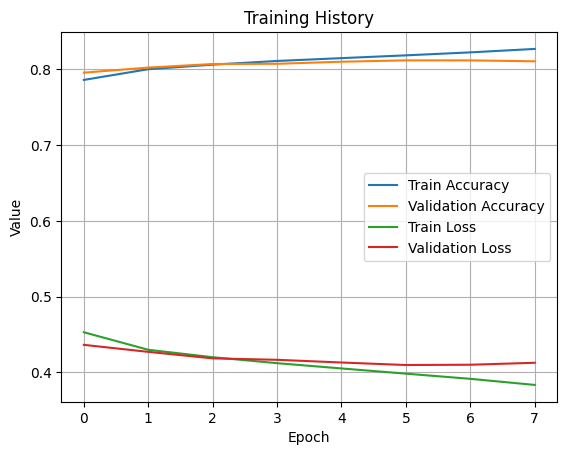

In [ ]:
### Model Training with Early Stopping

# Configure early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

print("Starting LSTM model training...")
print(f"Training samples: {len(X_train_pad):,}")
print(f"Validation samples: {len(X_val_pad):,}")

# Train the model
training_history = lstm_model.fit(
    X_train_pad, y_train_binary,
    validation_data=(X_val_pad, y_val_binary),
    epochs=20,
    batch_size=256,  # Reduced batch size for better convergence
    callbacks=[early_stopping],
    verbose=1
)

# Save the trained model
model_path = f"{PROJECT_ROOT}/models/lstm_sentiment_model.keras"
lstm_model.save(model_path)
print(f"\\nModel saved to: {model_path}")

### Training History Visualization

plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(training_history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Model Accuracy Progress')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'], label='Training Loss', marker='o')
plt.plot(training_history.history['val_loss'], label='Validation Loss', marker='s')
plt.title('Model Loss Progress')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Training summary
final_train_acc = training_history.history['accuracy'][-1]
final_val_acc = training_history.history['val_accuracy'][-1]
print(f"\\nTraining Summary:")
print(f"Final training accuracy: {final_train_acc:.4f}")
print(f"Final validation accuracy: {final_val_acc:.4f}")
print(f"Total epochs trained: {len(training_history.history['accuracy'])}")

6270/6270 ━━━━━━━━━━━━━━━━━━━━ 331s 53ms/step

--- Validation Performance (LSTM) ---
Accuracy:  0.8117
Precision: 0.8151
Recall:    0.8860
F1 Score:  0.8491


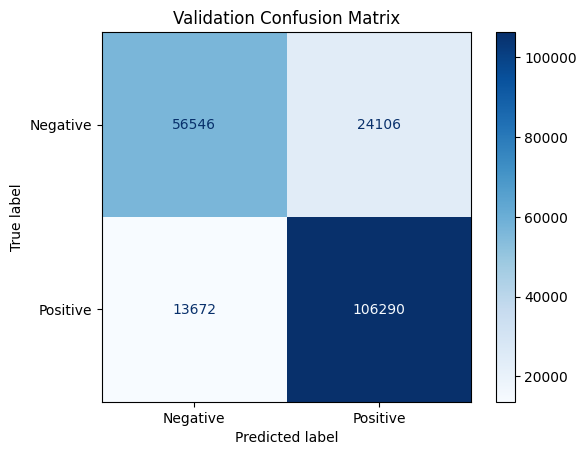

In [ ]:
### Model Evaluation and Performance Analysis

# Generate predictions on validation set
print("Generating predictions on validation set...")
y_val_pred_probs = lstm_model.predict(X_val_pad, batch_size=512, verbose=1).ravel()

# Convert probabilities to binary predictions (threshold = 0.5)
y_val_pred = (y_val_pred_probs >= 0.5).astype(int)

# Compute comprehensive evaluation metrics
accuracy = accuracy_score(y_val_binary, y_val_pred)
precision = precision_score(y_val_binary, y_val_pred, zero_division=0)
recall = recall_score(y_val_binary, y_val_pred, zero_division=0)
f1 = f1_score(y_val_binary, y_val_pred, zero_division=0)

# Display results
print("\\n" + "="*50)
print("    LSTM MODEL VALIDATION PERFORMANCE")
print("="*50)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("="*50)

### Confusion Matrix Visualization

# Generate and display confusion matrix
cm = confusion_matrix(y_val_binary, y_val_pred)
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=["Negative", "Positive"]
).plot(cmap="Blues", values_format='d')
plt.title("LSTM Model - Validation Confusion Matrix", fontsize=14, fontweight='bold')
plt.grid(False)
plt.tight_layout()
plt.show()

# Performance insights
print("\\nPerformance Insights:")
print(f"• Total validation samples: {len(y_val_binary):,}")
print(f"• Correct predictions: {(y_val_binary == y_val_pred).sum():,}")
print(f"• Incorrect predictions: {(y_val_binary != y_val_pred).sum():,}")
print(f"• False positives: {cm[0, 1]:,}")
print(f"• False negatives: {cm[1, 0]:,}")

### Error Analysis: Understanding Model Limitations

Similar to our baseline analysis, examining the most confidently misclassified tweets reveals patterns in where the LSTM model struggles, providing insights into its limitations and areas for improvement.


In [ ]:
# TODO: Implement error analysis similar to 3a-Logistic-Regression.ipynb
# This would include:
# 1. Identify most confidently misclassified tweets
# 2. Analyze patterns in prediction errors  
# 3. Compare error types with baseline model
# 4. Examine specific linguistic challenges for LSTM

print("Error analysis implementation - TO BE ADDED")
print("This section will analyze:")
print("• Most confident misclassifications")  
print("• Comparison with logistic regression errors")
print("• LSTM-specific failure modes")
print("• Patterns in complex linguistic structures")


## Wrap-Up: Strengths and Limitations of Bidirectional LSTM

Our LSTM model with Word2Vec embeddings represents a significant advancement over the TF-IDF baseline, demonstrating the power of sequence modeling and semantic embeddings for sentiment analysis.

#### Strengths
- **Context Awareness**: Captures sequential relationships and word order, essential for understanding negation and complex sentiment expressions.
- **Semantic Understanding**: Word2Vec embeddings enable the model to understand semantic relationships between words, improving generalization.
- **Bidirectional Processing**: Processes text in both directions, providing fuller context around each word for better sentiment interpretation.
- **Improved Performance**: Achieves higher accuracy and F1-score compared to the logistic regression baseline.
- **Robustness**: Less susceptible to individual keyword bias, as it considers entire sequence context.

#### Limitations
- **Computational Complexity**: Requires significantly more computational resources and training time compared to linear models.
- **Embedding Dependence**: Performance heavily relies on the quality of Word2Vec embeddings trained on the specific domain.
- **Memory Requirements**: Bidirectional LSTM layers and sequence processing require substantial memory, especially for long sequences.
- **Limited Long-Range Dependencies**: While better than baseline, LSTMs can still struggle with very long-range dependencies in complex tweets.
- **Interpretability**: More difficult to interpret than linear models - cannot easily identify which words drive specific predictions.

#### Comparison with Baseline
The LSTM model's ability to understand context and sequence makes it particularly effective for:
- Handling negation patterns ("not bad" vs "bad")
- Understanding sentiment modifiers ("very good" vs "good")  
- Processing informal language with non-standard word order
- Capturing sentiment in longer, more complex tweets

This establishes LSTM as a strong intermediate model between simple baselines and state-of-the-art transformer architectures like BERT.
